In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [45]:
bus_df = pd.read_csv(f'{DATA_DIR}/MTA_bus(1).csv')
bus_gdf = gpd.GeoDataFrame(bus_df, geometry=gpd.points_from_xy(bus_df['longitude'], bus_df['latitude'])).set_crs(CRS_PLOT)

In [46]:
b25_gdf = bus_gdf[bus_gdf['route'].str.contains('B25')]

In [47]:
b25_gdf = b25_gdf[['bus_id', 'x', 'datetime', 'latitude', 'longitude', 'geometry']]

In [48]:
b25_gdf = b25_gdf.sort_values(by=['bus_id', 'datetime'])

In [49]:
b25_gdf.to_csv(f'{EXPORTS_DIR}/b25_all_trajectories.csv', index=False)

<AxesSubplot:>

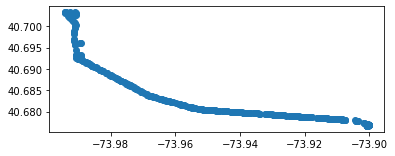

In [50]:
b25_gdf.plot()